Author: Mario Roca

In [2]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this lab specifically, we will generate random data (with some random noise), so that we know the "ground truth" function that represents the distribution. We will thus be able to see how well we can manage to approximate this function. In future labs, we will use "real" data for which we do not the ground truth distribution, similarly to lab 1.

# Linear regression

We will implement two ways to do linear regression.

In ***this part of this lab only***, since we are interested in recovering a ground truth function, we will not bother splitting the dataset into train/validatation/test sets. In general, *we obviously don't know the ground truth function*. So one of the only ways to ensure that we are not overfitting will be to split the dataset. This is what we will do in other sections and future labs.

## Data generation

Let's generate some fake data (area and age) for houses, and try to predict their price.

Let's start by generating $N$ 2-dimensional training samples, and concatenate them in a matrix $\mathbf{X}_{train}$ of size (N,2)

In [3]:
# Data generation
np.random.seed(42) # we use a random seed so that our random generation is reproducible
N = 50 # number of samples to generate

house_area = np.random.uniform(50,300,size=N) # generate N samples uniformly distributed from 50 to 300
house_age = np.random.uniform(0,150,size=N) # similar

X_train = np.concatenate([
    house_area.reshape(-1,1),
    house_age.reshape(-1,1)
], axis=1) # concatenate the featurs into one input matrix
print(f"Shape of the feature matrix: {X_train.shape}")

Shape of the feature matrix: (50, 2)


Now let's generate the labels $\mathbf{y}_{train}$. We will generate labels that are linear with respect to the input data, with some added random noise that can for instance represent naturally occuring randomness or measurements errors.

In [4]:
# Label generation
noise = np.random.normal(0,5,size=N) # generate some normally distribution random noise
house_price = 1.1 * house_area - 0.5 * house_age + noise # the target is a linear combination of inputs + noise

y_train = house_price
print(f"Shape of the labels vector: {y_train.shape}")

Shape of the labels vector: (50,)


Let's quickly visualize the relation between the target and each individual variable.

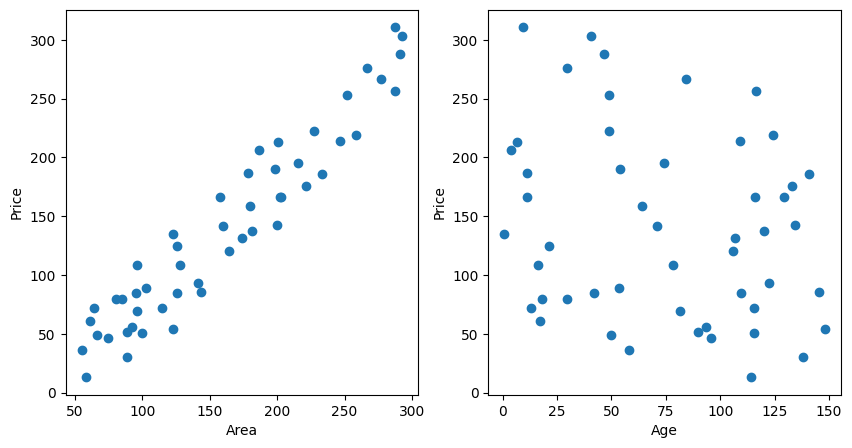

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5)) # create 2 plots size by size

# First scatter plot
ax1.scatter(house_area, house_price)
ax1.set_xlabel('Area')
ax1.set_ylabel('Price')

# Second scatter plot
ax2.scatter(house_age, house_price)
ax2.set_xlabel('Age')
ax2.set_ylabel('Price')
plt.show()

We can also display the ground truth lines:

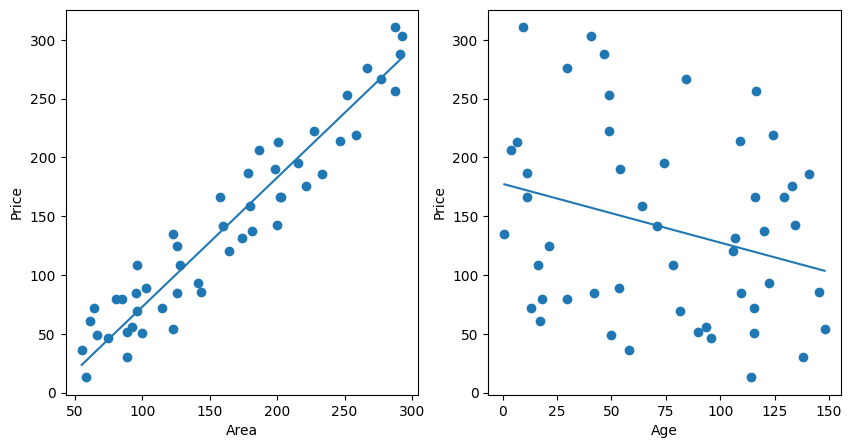

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5)) # create 2 plots size by size

# First scatter plot
ax1.scatter(house_area, house_price)
ax1.set_xlabel('Area')
ax1.set_ylabel('Price')
x_range_area = np.array([house_area.min(), house_area.max()]) # leftmost and rightmost points on the x axis
y_preds_area = 1.1 * x_range_area - 0.5 * house_age.mean() # corresponding points on the y_axis
ax1.plot(x_range_area, y_preds_area)


# Second scatter plot
ax2.scatter(house_age, house_price)
ax2.set_xlabel('Age')
ax2.set_ylabel('Price')
x_range_age = np.array([house_age.min(), house_age.max()]) # leftmost and rightmost points on the x axis
y_preds_age = 1.1 * house_area.mean() - 0.5 * x_range_age # corresponding points on the y_axis
ax2.plot(x_range_age, y_preds_age)
plt.show()

Notice that to draw the ground truth line for each variable, we also had to take into account the mean impact of the other variable.

## Linear regression implementation: gradient descent

**Are the generated data and ground truth function realistic?**

The data can be realistic for a city where the price per m2 is very low (around 1k per m2: small city in East Europe).
The ground truth funciton is realistic. The price grows linearly with the m2 and decreases for older apartments.

Now let's do linear regression! We will assume there is no intercept, i.e. $f(\mathbf{x}) = \mathbf{w}^\top\mathbf{x}$ (there is no additional $w_0$ term)

Given the parameters $\mathbf{w} = (w_1,w_2)^\top$ and the training data $\mathbf{X}$,
predictions can be made with $\hat{\mathbf{y}} = \mathbf{Xw}$

In [7]:
# For example, with an arbitrary vector w:
w_init = np.array([1,2]) # assign random values to w

y_est = X_train @ w_init # compute predictions
print(f"Shape of our predictions: {y_est.shape}")

Shape of our predictions: (50,)


**Implement a function that returns the Mean Square Error (MSE):**
$$J(\mathbf{w}) = \frac{1}{N}  \lVert \mathbf{y} - \mathbf{Xw} \rVert_2^2$$
**given the training data $\mathbf{X}$, labels $\mathbf{y}$ and model parameters $\mathbf{w}$**

In [8]:
def mse(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    """
    Compute the MSE

    Args:
        X: matrix (2D array) of features, shape (N, D)
        y: vector (1D array) of labels, shape (N,)
        w: vector (1D array) of parameters, shape (D,)
    """
     # Number of samples
    N = X.shape[0]
    # Compute the prediction error
    error = y - X @ w
    # Compute the MSE
    mse = np.square(error).mean() 
    
    return mse


**How can we estimate the gradient $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$?** (no code required either, just a formula)

*As seen in class the gradient of the loss function is $\frac{2}{N}\mathbf{X}^\top(\mathbf{Xw}-\mathbf{y})$*

***Bonus question: what if we did not have an analytical solution?*** (no code required either, just an *optional* very brief answer)

If we did not have an analytical solution, we could estimate the gradient numerically using finite differences: for each dimension of the parameters $\mathbf{w}$, apply a small change $\epsilon$ and measure how it impacts the loss.

The gradient of dimension $i$ could thus be estimated with:

$$\frac{\partial J(\mathbf{w})}{\partial {w}_i} \approx \frac{J(\mathbf{w} + \epsilon\mathbf{e}_i) - J(\mathbf{w})}{\epsilon}$$
 

where $\mathbf{e}_i$ is a unit vector along the $i$-th coordinate.

**Implement gradient descent:
$\mathbf{w}_{(t)} = \mathbf{w}_{(t-1)} - \alpha \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$**

**and determine suitable values for the parameters $\mathbf{w}$ using gradient descent on the training samples.**

It may be useful to print the training error at each step. If the loss/error is not decreasing, try a smaller value of the learning rate $\alpha$.

In [9]:
def compute_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    Compute the gradient of the loss
    
    Args:
        X: matrix (2D array) of features, shape (N, D)
        y: vector (1D array) of labels, shape (N,)
        w: vector (1D array) of parameters, shape (D,)

    Returns:
        gradients: vector (1D array) of gradient, shape (D,)
    """
    gradient = 2/N * X.T @ (X @ w - y)
    
    return gradient

In [10]:
def gradient_descent(X, y, alpha=1e-5, max_iterations=100, tol=1e-6) -> np.ndarray:
    """
    Perform gradient descent on training data, and return fitted parameters.
    
    Args:
        X: matrix (2D array) of features, shape (N, D)
        y: vector (1D array) of labels, shape (N,)
        alpha: learning rate, float
        max_iterations: maximum number of iterations, int
        tol: convergence tolerance, float

    Returns:
        w: vector (1D array) of estimated parameters, shape (D,)
    """
    w = w_new = w_init # random initialization

    for i in range(max_iterations):
        w_new = w - alpha * compute_gradient(X, y, w)
        # Stop the iterations if the change in weights is smaller than the tolerance
        if np.linalg.norm(w_new - w) < tol:
            print(f"Converged after {i} iterations")
            break
        w = w_new
        # Calculate the mse
        mse_ = mse(X, y, w)
        # Print the error to check if it's decreasing as expected
        if i % 10 == 0:
            print(f"MSE value at the iteration {i}: {mse_:.4f}")
    return w


In [11]:
gradient_descent(X_train, y_train, max_iterations=1000, tol=1e-4)

MSE value at the iteration 0: 13999.4299
MSE value at the iteration 10: 4414.0328
MSE value at the iteration 20: 1649.3249
MSE value at the iteration 30: 624.4820
MSE value at the iteration 40: 244.5854
MSE value at the iteration 50: 103.7625
MSE value at the iteration 60: 51.5611
MSE value at the iteration 70: 32.2108
MSE value at the iteration 80: 25.0378
MSE value at the iteration 90: 22.3789
MSE value at the iteration 100: 21.3933
MSE value at the iteration 110: 21.0279
MSE value at the iteration 120: 20.8925
MSE value at the iteration 130: 20.8423
MSE value at the iteration 140: 20.8236
Converged after 142 iterations


array([ 1.09011278, -0.48481852])

**Are your estimated values of the parameters consistent with the ground_truth?**

*Yes, the estimated values 1.09 and -0.48 are very near to the ground_truth values of 1.1 and -0.5.*

## Linear regression implementation: analytical solution and comparison

**Now use the closed-form solution to obtain good values for the parameters $\mathbf{w}$ using the training set.**

*As seen in class the analytical solution to find w is*
$$
\mathbf{w} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$



In [12]:
def analytic_solve(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Return parameters to the least square problem instance
    by using the analytical solution
    
    Args:
        X: matrix (2D array) of features, shape (N, D)
        y: vector (1D array) of labels, shape (N,)

    Returns:
        w: vector (1D array) of estimated parameters, shape (D,)
    """
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

**Display the exact values of the parameters $\mathbf{w}$.
Are they the same as the one you obtained from gradient descent?
Are they the same as the ground truth values? Why?**

In [13]:
analytic_solve(X_train, y_train)

array([ 1.0909023 , -0.48668339])

*The values of the parameters obtained with the analytical solution are very near to the ones obtained with the gradient descent. However, both solutions are not exactly the same of the ground truth values because we added noise during the generation of the data.*

In practice, a machine learning engineer does not waste time implementing standard algorithms.
Scikit-learn provides an implementation of a linear regression, among many other learning algorithms.

(Obviously, YOU are not wasting time, because you are learning. Implementing a linear regression is something *everyone* should do at least once in their life).

**Look at the documentation from scikit-learn, and train a linear regression on our data using the provided implementation.
Look at the coefficients $\mathbf{w}$. Are they similar to the ones you found?**

In [14]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

reg.coef_

array([ 1.07341215, -0.50560258])

*The coefficients found with sklearn are similar to the ones found with the implemented alorithms*

# Over- and under-fitting polynomials

## Data generation

Let's define a new "ground-truth" function $f(x) = \frac{\sin(x)}{x}$, and plot it on $[0,10]$

In [15]:
def f(x: float) -> float:
    """
    Take an float (or an array of floats as input)
    and apply the corresponding function
    """
    return np.sin(x) / x

Let's randomly sample $N$ points $\mathbf{X}_{}$ in range $[1,10]$, and create corresponding labels $\mathbf{y}_{}$ by applying this function and adding some random noise.

(Note: here, since we have a single input feature ($D=1$), $\mathbf{X}_{}$ is actually an $N$-dimensional vector and not an $(N \times D)$ matrix. We could therefore write $\mathbf{x}_{}$ (lowercase) instead. But since we may consider that a vector is an $(N \times 1)$ matrix, we will keep writing $\mathbf{X}_{}$ for the sake of consistency.)

In [16]:
# Data generation
np.random.seed(42) # we use a random seed so that our random generation is reproducible
N = 20 # number of samples to generate

X_full = np.random.uniform(1,10,size=N)
noise = np.random.randn(N)
y_full = f(X_full) + 0.1 * noise

Finally, let's display the sampled points and the ground truth function.

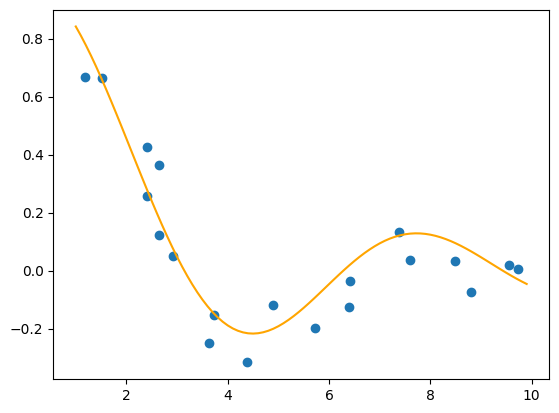

In [17]:
x_range = np.arange(1,10,0.1) # sample points along the x-axis
y_ground_truth = f(x_range) # compute corresponding points on the y-axis
plt.plot(x_range, y_ground_truth, color='orange') # plot the corresponding line
plt.scatter(X_full, y_full) # plot the sampled points
plt.show()

Notice that we do not have many training samples, as may be the case for some real use cases.

We will now assume *we do not know* the ground truth function. We will instead use the sampled points as training and testing examples to try to predict the corresponding labels, try to fit a polynomial curve and evaluate the results.

Let's start by splitting our data into a training a testing set:

In [18]:
# Training set
X_train = X_full[:12] # 12 first elements of X_full
y_train = y_full[:12] # 12 first labels of y_full
# Testing set
X_test = X_full[12:] # remaining elements of X_full
y_test = y_full[12:] # remaining elements of y_full

## Fitting polynomials

**Does it look like fitting a simple linear regression would provide good predictions?**

*Even if we didn't know the function f(), we could see that the data points this time follow a curve shape*

**Complete the following function that create polynomial features**

In [19]:
def get_polynomial_features(X: np.ndarray, degree=3) -> np.ndarray:
    """
    Return polynomial features;
    if i-th element of input X is a,
    i-th output element is 1 + a + a^2 + ... + a^degree
    
    Args:
        X: vector (1D array) of features, shape (N,)
        degree: int, the maximum degree of the polynomial
    
    Returns:
        polynomial_features: matrix of shape (N, degree+1)
    """

    features = [X ** _ for  _ in range(degree + 1)]
    polynomial_features = np.column_stack(features)
    
    return polynomial_features


In [20]:
X_train_poly = get_polynomial_features(X_train, degree=3)

**Fit a polynomial of degree 3 to the training data. Plot the corresponding curve along with the training samples.**

To achieve this, you may use either the Scikit-learn implementation of linear regression, your own implementation, or any other method that you deem relevant.

(Optionnaly, go directly to next question, which also includes this question.)

In [21]:
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train_poly, y_train)

X_test_poly = get_polynomial_features(X_test, degree=3)
y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.013042755241654009


In [33]:
def plot_curve(model, degree):
    # Generate smooth X values for plotting the curve
    X_smooth = np.linspace(X_full.min(), X_full.max(), 100)

    # Generate polynomial features for these smooth X values
    X_smooth_poly = get_polynomial_features(X_smooth, degree)

    # Predict y values using the model
    y_smooth_pred = model.predict(X_smooth_poly)

    # Plot the model curve along with the original data points
    plt.plot(X_smooth, y_smooth_pred, color='orange', label=f'Polynomial Regression - Degree {degree}')
    plt.scatter(X_full, y_full, color='blue', label='Data points')  # Original data points
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()


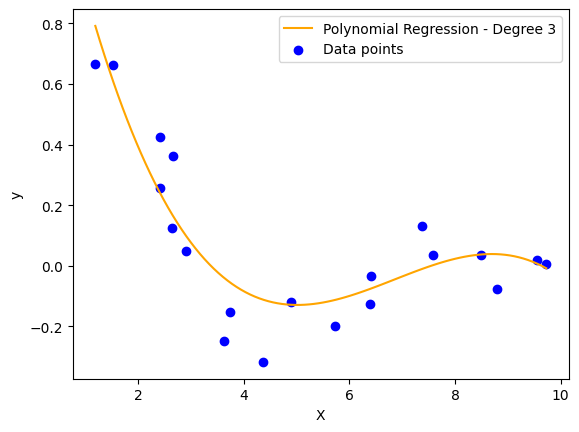

In [34]:
plot_curve(model, degree=3)

**Do the same for degrees 1 to 10. Which degree seems to yield the lowest training error?**

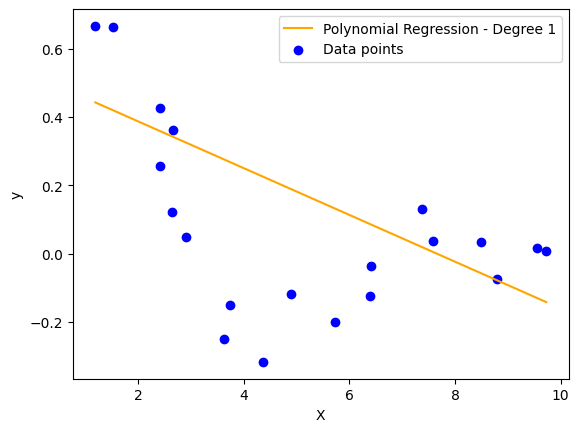

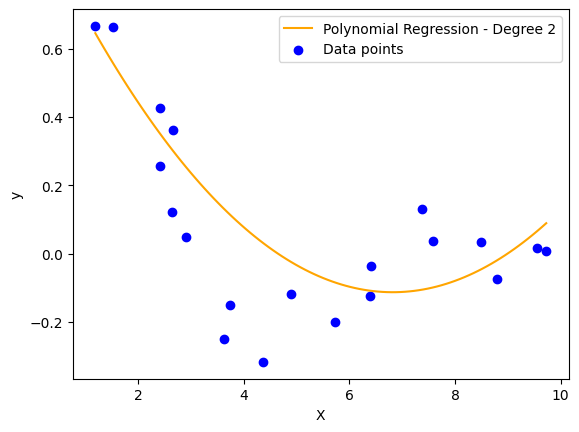

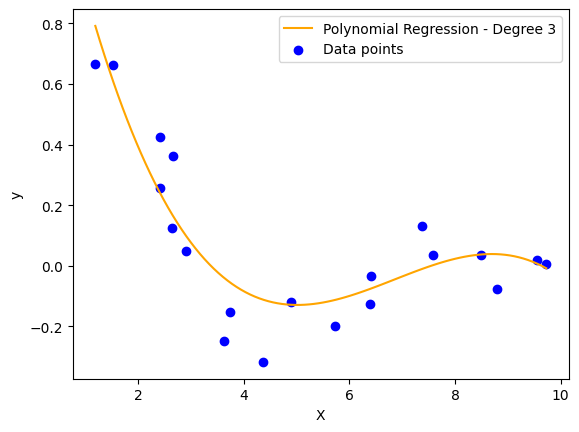

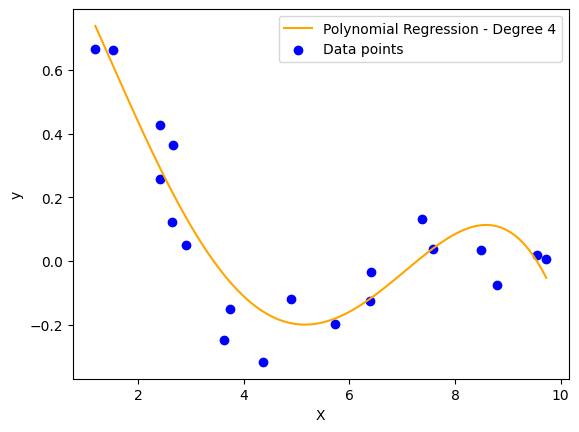

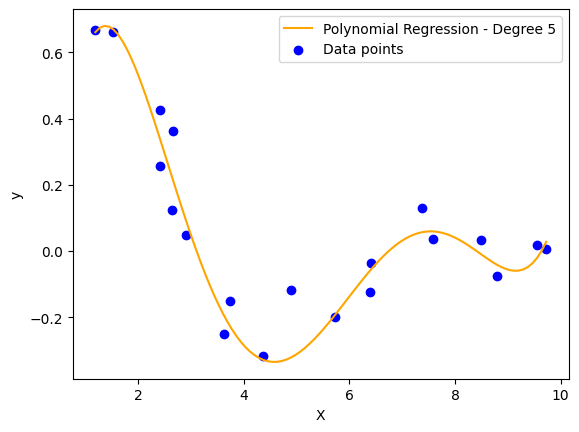

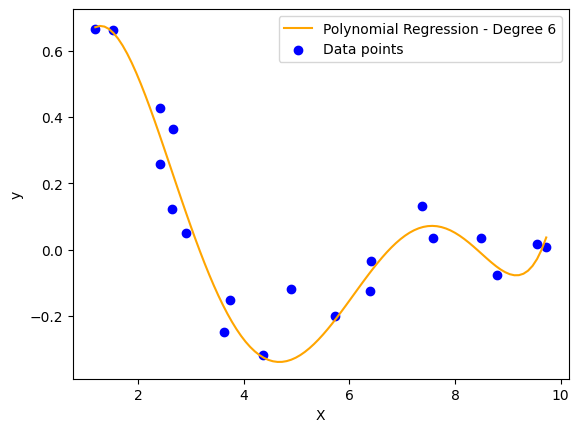

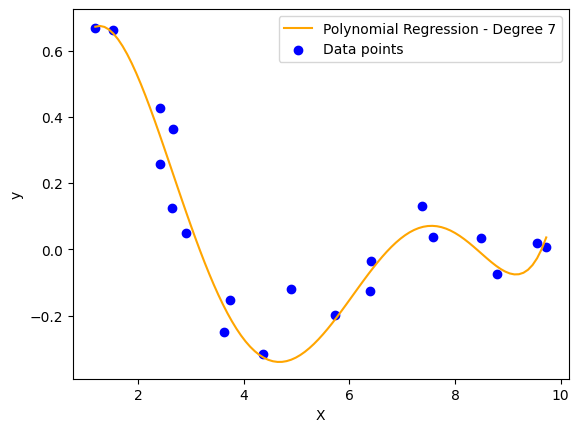

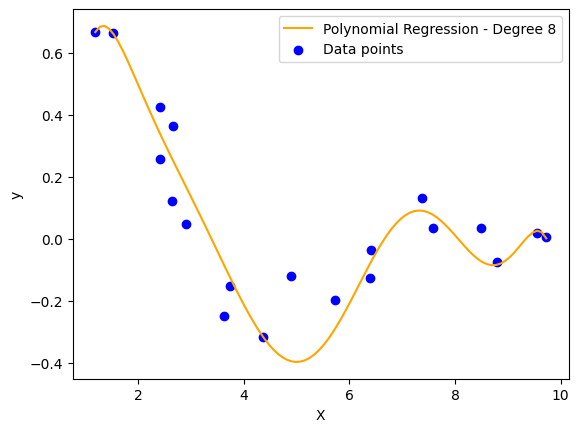

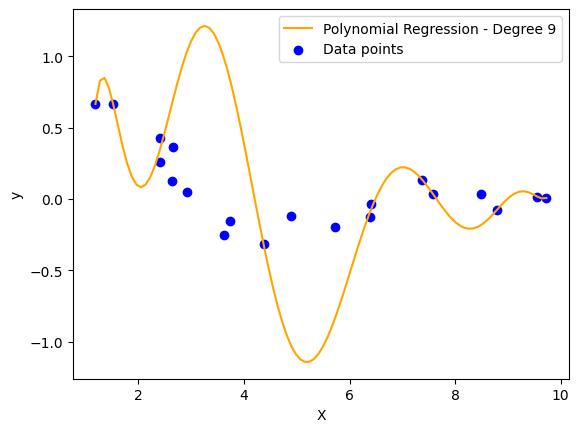

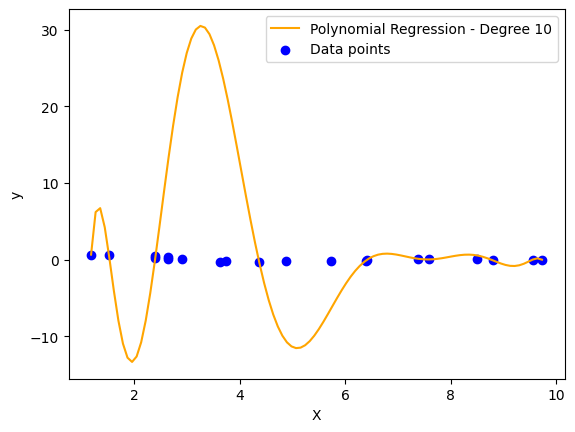

In [30]:
models = {}
X_train_poly = {}
for i in range (1, 11):
    models[i] = LinearRegression()
    X_train_poly[i] = get_polynomial_features(X_train, degree=i)
    models[i].fit(X_train_poly[i], y_train)
    plot_curve(models[i], degree=i)

*The curve that best follow the data seems to be the one with degree = 5*

## Measuring error

**What is the training error for each of the polynomial degree we fitted? What about the test error?**

You may plot the train and test error with respect to the degree of the polynomials

In [35]:
# Define a function to compute MSE

def mean_square_error(y_est: np.ndarray, y: np.ndarray) -> float:
    """
    Compute the MSE from predictions and ground truth labels

    Args:
        y_est: vector of estimated labels, shape (N,)
        y: vector of true labels, shape (N,)
    """
    squared_diff = (y - y_est) ** 2  # Calculate squared differences
    mse = np.mean(squared_diff)  # Calculate mean of the squared differences
    return mse

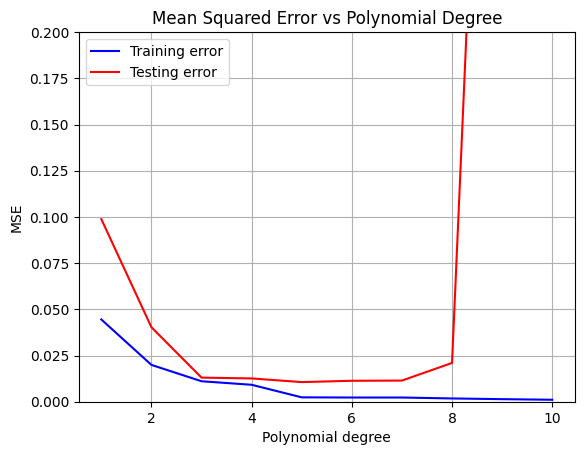

In [42]:
m_s_train_errors = {}
m_s_test_errors = {}
for i in range(1, 11):
    train_pred = models[i].predict(X_train_poly[i])
    m_s_train_errors[i] = mean_square_error(train_pred, y_train)

    X_test_poly = get_polynomial_features(X_test, degree=i)
    test_pred = models[i].predict(X_test_poly)
    m_s_test_errors[i] = mean_square_error(test_pred, y_test)

plt.plot(range(1, 11), list(m_s_train_errors.values()), color="blue", label=f'Training error')
plt.plot(range(1, 11), list(m_s_test_errors.values()), color="red", label=f'Testing error')

# Plot settings
plt.ylim(0, 0.2)
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Mean Squared Error vs Polynomial Degree")
plt.legend()
plt.grid()
plt.show()

**Interpret this in terms of under- and over-fitting**

*Polynomials of degrees 1 and 2 exhibit underfitting, as their models are too simplistic to capture the underlying curvature of the data. In contrast, polynomials of degrees 7, 8, and 9 show very low training errors but exhibit diverging test errors, indicating a clear overfitting situation. These models are overly complex, failing to generalize well to unseen data.*

Final note: here, the degree of the polynomial could typically be considered to be a hyper-parameter of the model. We did not do a proper selection of this hyper-parameter using a validation set, but ideally, we should have done so instead of selecting the best value for the degree direclty on the test set. Otherwise, this could lead to inaccurate estimate of the performance of the model.